# 🧠 Seminar 3: Object Detection Fine-Tuning

We will explore:
1. Sliding Window with Haar Cascades (Classical Method)
2. Faster R-CNN (Inference)
3. MobileNetV2-SSD (Inference)
4. YOLOv8 (Inference & Fine-tuning)
5. **Additional** zero-shot modern approach

We will use the [PASCAL VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/) dataset for demonstration and testing.

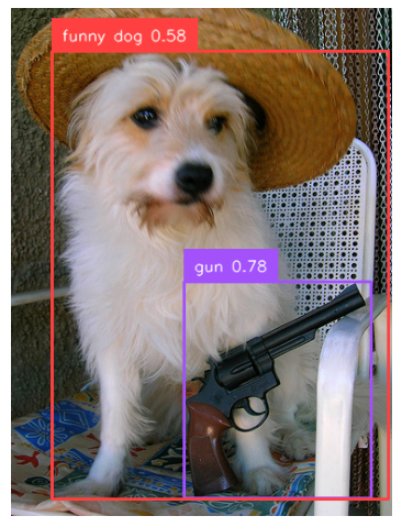


# Prerequisites

In [ ]:
# Install necessary libraries
!pip install ultralytics torch torchvision torchaudio opencv-python-headless matplotlib numpy requests tqdm pyyaml -q

import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, fasterrcnn_resnet50_fpn
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights, ssdlite320_mobilenet_v3_large
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import VOCDetection
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

from ultralytics import YOLO
import yaml # For writing YAML file

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import tarfile
from tqdm.notebook import tqdm
from PIL import Image
import xml.etree.ElementTree as ET # For parsing VOC XML annotations

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed all
def seed_all(seed=42):
    """Seeds all random number generators for reproducibility."""
    print(f"Setting seed to {seed}")
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_all()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [ ]:
# Define the subset of PASCAL VOC classes we want to use
SELECTED_CLASSES = ["person", "cat", "dog", "car", "horse"]

# Create a mapping from selected class name to a new contiguous index (0, 1, 2...)
CLASS_NAME_TO_ID = {name: i for i, name in enumerate(SELECTED_CLASSES)}
ID_TO_CLASS_NAME = {i: name for name, i in CLASS_NAME_TO_ID.items()}
NUM_SUBSET_CLASSES = len(SELECTED_CLASSES)

print(f"Selected {NUM_SUBSET_CLASSES} classes: {SELECTED_CLASSES}")
print(f"Class mapping (Name -> ID): {CLASS_NAME_TO_ID}")
print(f"Class mapping (ID -> Name): {ID_TO_CLASS_NAME}")

# COCO class names (for reference when using pre-trained models)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Selected 5 classes: ['person', 'cat', 'dog', 'car', 'horse']
Class mapping (Name -> ID): {'person': 0, 'cat': 1, 'dog': 2, 'car': 3, 'horse': 4}
Class mapping (ID -> Name): {0: 'person', 1: 'cat', 2: 'dog', 3: 'car', 4: 'horse'}


In [ ]:
def visualize_detections_ax(image, ax, boxes, labels, scores=None, class_id_to_name=None, threshold=0.5, title="Detections", is_coco=False):
    """Draws bounding boxes on a given Matplotlib Axes object."""
    # Convert PIL Image to NumPy array for drawing
    img_np = np.array(image).copy()
    if img_np.ndim == 2: # Grayscale
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)

    if torch.is_tensor(boxes):
        boxes = boxes.cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.cpu().numpy()
    if scores is not None and torch.is_tensor(scores):
        scores = scores.cpu().numpy()

    # Use COCO names if specified, otherwise use the provided mapping
    active_class_names = COCO_INSTANCE_CATEGORY_NAMES if is_coco else class_id_to_name
    num_colors = len(active_class_names) if active_class_names else 20
    colors = plt.cm.get_cmap('tab20', num_colors)

    valid_detections = 0
    for i in range(len(boxes)):
        if scores is not None and scores[i] < threshold:
            continue
        valid_detections += 1

        box = boxes[i].astype(int)
        label_idx = int(labels[i])

        # Handle potential index out of bounds if label doesn't exist in mapping
        label_text = f"Unknown ({label_idx})"
        color_idx = 0 # Default color index
        if active_class_names and 0 <= label_idx < len(active_class_names):
             # Check if the ID exists in our target mapping (relevant if not using COCO names)
             if not is_coco and label_idx in active_class_names:
                label_text = active_class_names[label_idx]
                color_idx = label_idx # Use the mapped ID for color
             elif is_coco:
                 label_text = active_class_names[label_idx]
                 # Try to find the COCO label in our selected classes for consistent coloring (best effort)
                 coco_name = label_text.lower()
                 if coco_name in CLASS_NAME_TO_ID:
                     color_idx = CLASS_NAME_TO_ID[coco_name]
                 else:
                     color_idx = label_idx # Fallback to original COCO index for color
             else:
                 # Label ID is valid but not in the expected map - use default text
                 pass # Keep 'Unknown' text

        else:
             # Label index is out of bounds for the provided list
             pass # Keep 'Unknown' text

        if scores is not None:
             label_text += f": {scores[i]:.2f}"

        # Get color, handle potential index reuse for coloring stability
        color = colors(color_idx % colors.N)[:3] # Get RGB tuple (0-1 range)
        color_cv = tuple(int(c * 255) for c in color) # Convert to 0-255 for CV2

        pt1 = (box[0], box[1])
        pt2 = (box[2], box[3])
        cv2.rectangle(img_np, pt1, pt2, color_cv, 2)

        # Put text background
        (text_width, text_height), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_np, (pt1[0], pt1[1] - text_height - baseline), (pt1[0] + text_width, pt1[1]), color_cv, -1)
        # Put text itself
        cv2.putText(img_np, label_text, (pt1[0], pt1[1] - baseline // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    ax.imshow(img_np)
    ax.set_title(f"{title}\n({valid_detections} detects > {threshold:.2f})")
    ax.axis('off')

def plot_model_results_grid(model_name, sample_imgs, model_outputs, class_id_to_name, threshold=0.5, is_coco=False):
    """Plots a 2x3 grid showing model's detection results on sample images."""
    n = len(sample_imgs)
    if n >= 3:
      fig, axs = plt.subplots(2, 3, figsize=(16, 9))
    else:
      fig, axs = plt.subplots(1, n, figsize=(10, 5))
    fig.suptitle(f"{model_name} Detections (Threshold: {threshold})", fontsize=14)
    axs = axs.ravel() # Flatten axes array for easy iteration

    if len(model_outputs) != len(sample_imgs):
        print(f"Error: Number of model outputs ({len(model_outputs)}) does not match number of sample images ({len(sample_imgs)}).")
        # Fill grid with original images instead
        for i, img in enumerate(sample_imgs):
            if i < len(axs):
                axs[i].imshow(img)
                axs[i].set_title(f"Sample {i+1} (No Output)")
                axs[i].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    for i, img in enumerate(sample_imgs):
        if i >= len(axs): break # Should not happen with 6 samples and 2x3 grid

        output = model_outputs[i] # Get detections for this specific image
        # Adapt based on output format (YOLO is different from Torchvision)
        if isinstance(output, dict): # Torchvision format
            boxes = output.get('boxes', torch.empty((0, 4)))
            labels = output.get('labels', torch.empty((0,), dtype=torch.long))
            scores = output.get('scores', torch.empty((0,)))
        elif hasattr(output, 'boxes'): # Ultralytics/YOLO format
             # Ensure correct format and device handling
             boxes_data = output.boxes.xyxy.cpu() if output.boxes is not None else torch.empty((0, 4))
             scores_data = output.boxes.conf.cpu() if output.boxes is not None else torch.empty((0,))
             labels_data = output.boxes.cls.cpu().long() if output.boxes is not None else torch.empty((0,), dtype=torch.long)

             # Ultralytics might predict COCO classes even after fine-tuning if mapping is complex
             # For fine-tuned YOLO, we expect labels 0..N-1 corresponding to our subset
             # We will use our ID_TO_CLASS_NAME map directly
             boxes, scores, labels = boxes_data, scores_data, labels_data
        else: # Fallback for unexpected format
             boxes, labels, scores = torch.empty((0, 4)), torch.empty((0,), dtype=torch.long), torch.empty((0,))

        visualize_detections_ax(img, axs[i], boxes, labels, scores,
                                class_id_to_name=class_id_to_name, # Pass the correct map
                                threshold=threshold,
                                title=f"Sample {i+1}",
                                is_coco=is_coco) # Flag if using COCO names

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()


In [ ]:
# Define basic transforms (more sophisticated ones might be needed for training)
basic_transform = T.Compose([
    T.ToTensor(),
])

def download_voc():
    data_dir = "./pascal_voc_subset"
    os.makedirs(data_dir, exist_ok=True)
    voc_root_dir = os.path.join(data_dir, "VOCdevkit", "VOC2012")

    print("Downloading PASCAL VOC 2012...")
    _ = VOCDetection(root=data_dir, year='2012', image_set='train', download=True)
    _ = VOCDetection(root=data_dir, year='2012', image_set='val', download=False) # Already downloaded
    print("Dataset download/verification successful using torchvision.")

# Function to parse VOC XML annotation file
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []
    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        difficult = int(obj.find('difficult').text)
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        objects.append({
            'name': name,
            'difficult': difficult,
            'bbox': [xmin, ymin, xmax, ymax]
        })
    return objects, (img_width, img_height)

# Define the custom Dataset filtering for selected classes
class VOCSubsetDataset(Dataset):
    def __init__(self, root, year='2012', image_set='train', selected_classes_map=None, transform=None):
        self.root = root
        self.image_set = image_set
        self.transform = transform
        self.selected_classes_map = selected_classes_map or {}
        self.voc_root = os.path.join(self.root, "VOCdevkit", f"VOC{year}")
        self.images_dir = os.path.join(self.voc_root, "JPEGImages")
        self.annotations_dir = os.path.join(self.voc_root, "Annotations")
        self.image_set_file = os.path.join(self.voc_root, "ImageSets", "Main", f"{image_set}.txt")

        with open(self.image_set_file, 'r') as f:
            self.ids = [x.strip() for x in f.readlines()]

        # Pre-filter image IDs to only include those with at least one selected object
        self.filtered_ids = []
        print(f"Filtering {image_set} set for selected classes...")
        for img_id in tqdm(self.ids):
            ann_path = os.path.join(self.annotations_dir, f"{img_id}.xml")
            objects, _ = parse_voc_xml(ann_path)
            has_selected_object = False
            for obj in objects:
                if obj['name'] in self.selected_classes_map and obj['difficult'] == 0:
                    has_selected_object = True
                    break
            if has_selected_object:
                self.filtered_ids.append(img_id)
        print(f"Original {image_set} size: {len(self.ids)}, Filtered size: {len(self.filtered_ids)}")

    def __getitem__(self, index):
        img_id = self.filtered_ids[index]
        img_path = os.path.join(self.images_dir, f"{img_id}.jpg")
        ann_path = os.path.join(self.annotations_dir, f"{img_id}.xml")

        img = Image.open(img_path).convert("RGB")
        objects, (img_w, img_h) = parse_voc_xml(ann_path)

        boxes = []
        labels = []
        for obj in objects:
            # Keep only selected classes and non-difficult objects
            if obj['name'] in self.selected_classes_map and obj['difficult'] == 0:
                # Map original class name to our new contiguous ID
                label_id = self.selected_classes_map[obj['name']]
                labels.append(label_id)
                boxes.append(obj['bbox'])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Ensure labels are long integers
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # Required fields for torchvision models
        target["image_id"] = torch.tensor([index]) # Use filtered index as image_id
        if boxes.shape[0] > 0:
          target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
          # Handle cases with no objects after filtering
          target["area"] = torch.tensor([], dtype=torch.float32)
          # Ensure boxes tensor still has shape [0, 4]
          target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)


        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64) # Assume no crowd

        if self.transform:
            img = self.transform(img)

        return img, target # Return image and target dictionary

    def __len__(self):
        return len(self.filtered_ids)


In [ ]:
# Data converting for YOLO
def convert_voc_to_yolo(image_set='train'):
    print(f"Converting VOC {image_set} set to YOLO format for selected classes...")

    voc_year = '2012'
    voc_devkit_path = os.path.join("./pascal_voc_subset", "VOCdevkit")
    voc_dataset_root = os.path.join(voc_devkit_path, f"VOC{voc_year}")
    image_set_file = os.path.join(voc_dataset_root, "ImageSets", "Main", f"{image_set}.txt")
    annotations_dir = os.path.join(voc_dataset_root, "Annotations")
    images_dir = os.path.join(voc_dataset_root, "JPEGImages")

    yolo_data_dir = "./yolo_voc_subset"
    yolo_images_train = os.path.join(yolo_data_dir, "images", "train")
    yolo_labels_train = os.path.join(yolo_data_dir, "labels", "train")
    yolo_images_val = os.path.join(yolo_data_dir, "images", "val")
    yolo_labels_val = os.path.join(yolo_data_dir, "labels", "val")

    target_img_dir = yolo_images_train if image_set == 'train' else yolo_images_val
    target_lbl_dir = yolo_labels_train if image_set == 'train' else yolo_labels_val

    try:
        with open(image_set_file, 'r') as f:
            image_ids = [x.strip() for x in f.readlines()]
    except FileNotFoundError:
        print(f"Error: {image_set_file} not found. Ensure dataset downloaded correctly.")
        return False

    conversion_count = 0
    for img_id in tqdm(image_ids):
        ann_path = os.path.join(annotations_dir, f"{img_id}.xml")
        img_path = os.path.join(images_dir, f"{img_id}.jpg")

        if not os.path.exists(ann_path) or not os.path.exists(img_path):
            # print(f"Warning: Missing annotation or image for {img_id}. Skipping.")
            continue # Skip if files are missing

        objects, (img_w, img_h) = parse_voc_xml(ann_path)
        yolo_labels = []
        has_selected_object = False

        for obj in objects:
            if obj['name'] in CLASS_NAME_TO_ID and obj['difficult'] == 0:
                has_selected_object = True
                class_id = CLASS_NAME_TO_ID[obj['name']]
                xmin, ymin, xmax, ymax = obj['bbox']

                # Convert to YOLO format: center_x, center_y, width, height (normalized)
                x_center = ((xmin + xmax) / 2) / img_w
                y_center = ((ymin + ymax) / 2) / img_h
                width = (xmax - xmin) / img_w
                height = (ymax - ymin) / img_h

                yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Only copy image and create label file if it contains at least one selected object
        if has_selected_object:
            # Copy image file
            target_img_path = os.path.join(target_img_dir, f"{img_id}.jpg")
            if not os.path.exists(target_img_path): # Avoid re-copying
                 try:
                     import shutil
                     shutil.copy(img_path, target_img_path)
                 except Exception as copy_err:
                     print(f"Warning: Failed to copy {img_path}: {copy_err}")
                     continue # Skip if copy fails

            # Write label file
            target_lbl_path = os.path.join(target_lbl_dir, f"{img_id}.txt")
            with open(target_lbl_path, 'w') as f_label:
                f_label.write("\n".join(yolo_labels))
            conversion_count += 1

    print(f"Finished converting {image_set}. Processed {conversion_count} images with selected objects.")


def convert_data():
    # Initially it was written for yolo
    yolo_data_dir = "./yolo_voc_subset"
    yolo_images_train = os.path.join(yolo_data_dir, "images", "train")
    yolo_labels_train = os.path.join(yolo_data_dir, "labels", "train")
    yolo_images_val = os.path.join(yolo_data_dir, "images", "val")
    yolo_labels_val = os.path.join(yolo_data_dir, "labels", "val")

    os.makedirs(yolo_images_train, exist_ok=True)
    os.makedirs(yolo_labels_train, exist_ok=True)
    os.makedirs(yolo_images_val, exist_ok=True)
    os.makedirs(yolo_labels_val, exist_ok=True)

    # Run conversion for both train and val sets
    yolo_train_ready = convert_voc_to_yolo('train')
    yolo_val_ready = convert_voc_to_yolo('val')
    yolo_data_prepared = yolo_train_ready and yolo_val_ready

    # Create the YAML file for YOLO training
    yolo_yaml_path = os.path.join(yolo_data_dir, "voc_subset.yaml")
    yolo_yaml_content = {
        'path': os.path.abspath(yolo_data_dir), # Root directory
        'train': 'images/train', # Path relative to 'path'
        'val': 'images/val',     # Path relative to 'path'
        'names': ID_TO_CLASS_NAME # Use our subset class map
    }

    with open(yolo_yaml_path, 'w') as f:
        yaml.dump(yolo_yaml_content, f, default_flow_style=False)

    print(f"YOLO dataset YAML file created at: {yolo_yaml_path}")
    print("--- YAML Content ---")
    print(yaml.dump(yolo_yaml_content))
    print("--------------------")

# Display yolo data
def prepare_and_display():
    num_samples = 6
    sample_images_pil = []
    sample_image_paths = [] # For YOLO inference
    sample_targets = [] # Store corresponding targets if needed
    yolo_data_dir = "./yolo_voc_subset"
    yolo_images_val = os.path.join(yolo_data_dir, "images", "val")

    # Get samples from the converted validation set images for consistency
    val_image_files = [f for f in os.listdir(yolo_images_val) if f.endswith(".jpg")]
    if len(val_image_files) >= num_samples:
      # pics for seminar
      # val_image_files[1], val_image_files[12], val_image_files[21], val_image_files[26], val_image_files[35], val_image_files[48]
        selected_files = ['2008_008192.jpg', '2011_002575.jpg', '2008_004054.jpg', '2011_000202.jpg', '2008_003514.jpg', '2010_001645.jpg']
        print(f"Selected {num_samples} random samples from YOLO validation images.")
        for filename in selected_files:
            img_path = os.path.join(yolo_images_val, filename)
            img_pil = Image.open(img_path).convert("RGB")
            sample_images_pil.append(img_pil)
            sample_image_paths.append(img_path)


    # Display the selected samples in a grid
    print(f"\nDisplaying {len(sample_images_pil)} sample images:")
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()
    for i, img in enumerate(sample_images_pil):
        if i >= len(axs): break
        axs[i].imshow(img)
        axs[i].set_title(f"Sample Image {i+1}")
        axs[i].axis('off')
    plt.suptitle("Selected Test Images")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return sample_images_pil, sample_image_paths

In [ ]:
def download_cascade(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading cascade from {url} to {save_path}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # Check for download errors
            total_size = int(response.headers.get('content-length', 0))
            block_size = 1024
            t = tqdm(total=total_size, unit='iB', unit_scale=True, desc=os.path.basename(save_path))
            with open(save_path, 'wb') as f:
                for data in response.iter_content(block_size):
                    t.update(len(data))
                    f.write(data)
            t.close()
            if total_size != 0 and t.n != total_size:
                print("Warning: Download size mismatch.")
            print("Download complete.")
            return True
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {url}: {e}")
            return False
        except IOError as e:
            print(f"Error writing file {save_path}: {e}")
            return False
    else:
        print(f"Cascade file already exists: {save_path}")
        return True

# Data Preparation
Object detection datasets are more complex than classification datasets like CIFAR-10. They include not only the image but also bounding box coordinates and class labels for each object within the image.

PASCAL VOC (Visual Object Classes) is a popular benchmark dataset. We'll use VOC 2012. It contains 20 object classes.

We will download the dataset and select a few sample images for testing our models.

In [ ]:
download_voc()
convert_data()
sample_images_pil, sample_image_paths = prepare_and_display()

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


## Model 1: Sliding Window with Haar Cascades (Classical Method)

### Theory
Before deep learning dominated computer vision, methods like **Haar Cascades** combined with a **sliding window** were popular for object detection, particularly face detection.

* **[Integral image](https://en.wikipedia.org/wiki/Summed-area_table)** : the value at any point $(x, y)$ is the sum of all the pixels above and to the left of $(x, y)$: $$I(x, y) = \sum_{x^\prime \leq x, y^\prime \leq y} i(x^\prime, y^\prime),$$ where $i(x,y)$ is the value of the pixel at $(x,y)$.
* **Haar-like Features:** These are simple rectangular features (differences of sums of pixel intensities) that are computationally cheap to calculate using an integral image.
![](https://www.researchgate.net/profile/Xuan-Thuan-Nguyen/publication/261204570/figure/fig1/AS:356802890878977@1462079846527/An-example-of-Haar-like-features-In-order-to-get-the-Haar-like-feature-value-areas-of.png)
* **Cascade Classifier:** A cascade of increasingly complex classifiers (like AdaBoost) is used. Early stages quickly reject non-object regions using simple features, while later stages use more complex features to refine detections. This makes the process efficient.
* **Sliding Window:** The detector (cascade) is applied at multiple locations and scales across the image.

This method is fast for specific trained object classes (like faces, eyes, cars) but less general and less robust to variations compared to deep learning models. It requires training a specific cascade for each object type.

### Detection with Pre-trained Haar Cascade
OpenCV provides several pre-trained Haar cascades. We will use one for detecting humans as an example.


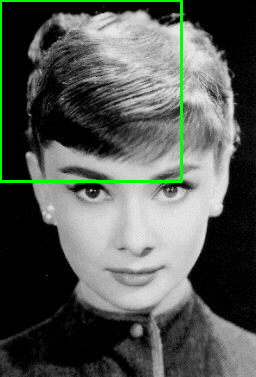


In [ ]:
haar_human_face_url = "https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
haar_human_face_path = "./haarcascade_frontalface_alt2.xml"

download_cascade(haar_human_face_url, haar_human_face_path)

print("Loading specific Haar Cascades...")
# Load Human Face Cascade
human_cascade = cv2.CascadeClassifier(haar_human_face_path)
human_cascade_loaded = True

# Check if required class IDs exist in our subset map
person_class_id = CLASS_NAME_TO_ID.get('person')

haarcascade_frontalface_alt2.xml:   0%|          | 0.00/87.3k [00:00<?, ?iB/s]

Download complete.
Loading specific Haar Cascades...


Processing Images:   0%|          | 0/2 [00:00<?, ?it/s]

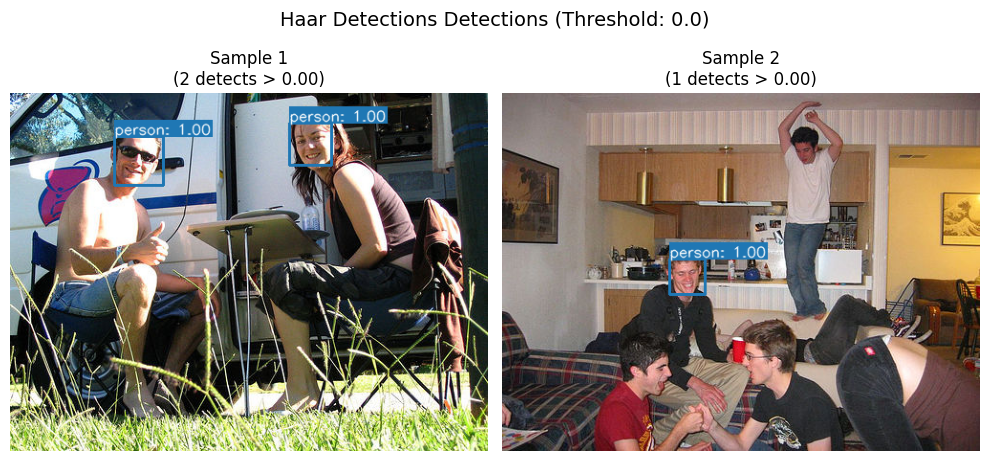

In [ ]:
haar_specific_results = [] # Store results for each image

for i, img_pil in enumerate(tqdm(sample_images_pil[1:3], desc="Processing Images")):
    cascade_to_use, target_class_id = human_cascade, person_class_id

    boxes_haar = []
    labels_haar = []
    scores_haar = [] # Dummy scores

    if cascade_to_use and target_class_id is not None:
        # Convert image for OpenCV
        img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray) # Improve contrast

        # Run detection with the assigned cascade
        detections = cascade_to_use.detectMultiScale(
            gray,
            scaleFactor=1.1,    # Default: 1.1-1.4. Smaller values detect more sizes but slower.
            minNeighbors=3,     # Default: 3-6. Higher values mean stricter detection (fewer false positives).
            minSize=(30, 30)    # Minimum object size to detect.
        )

        # Convert (x, y, w, h) to our format
        for (x, y, w, h) in detections:
            boxes_haar.append([x, y, x + w, y + h])
            labels_haar.append(target_class_id) # Use the ID corresponding to the cascade type
            scores_haar.append(1.0) # Haar cascades don't provide confidence scores

    # Store results for this image (even if empty)
    haar_specific_results.append({
        'boxes': torch.tensor(boxes_haar, dtype=torch.float32),
        'labels': torch.tensor(labels_haar, dtype=torch.int64),
        'scores': torch.tensor(scores_haar, dtype=torch.float32)
    })

# Display results in a grid using our subset class names
if 'ID_TO_CLASS_NAME' in globals():
      plot_model_results_grid(
          "Haar Detections",
          sample_images_pil[1:3],
          haar_specific_results,
          class_id_to_name=ID_TO_CLASS_NAME,
          threshold=0.0,
          is_coco=False
      )


## Model 2: Faster R-CNN (TorchVision)

### Theory
Faster R-CNN (Region-based Convolutional Neural Network) is a foundational **two-stage detector**.
1.  **Stage 1. Region Proposal Network (RPN):** A small convolutional network scans the feature map (output of a backbone CNN like ResNet) and proposes potential regions ("anchors") that might contain objects.
2.  **Stage 2. Detection Network:** For each proposed region, features are extracted (using RoIPooling or RoIAlign) and fed into fully connected layers to classify the object within the region and refine the bounding box coordinates.

It's generally more accurate than single-stage detectors for complex scenes but often slower.

### Inference
We will use a Faster R-CNN model with a ResNet-50 backbone, pre-trained on COCO.

In [ ]:
# Load pre-trained model
print("Loading ORIGINAL COCO pre-trained Faster R-CNN for inference comparison.")
weights_frcnn = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
frcnn_model = fasterrcnn_resnet50_fpn(weights=weights_frcnn)
frcnn_model.eval() # Set to evaluation mode
frcnn_model.to(device)
frcnn_preprocess = weights_frcnn.transforms()
print("Original Faster R-CNN model ready for inference.")

Loading ORIGINAL COCO pre-trained Faster R-CNN for inference comparison.


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 146MB/s]


Original Faster R-CNN model ready for inference.


In [ ]:
print("Running inference with COCO pre-trained Faster R-CNN...")
frcnn_results = []
detection_threshold = 0.9 # Confidence

with torch.no_grad():
    for img_pil in tqdm(sample_images_pil):
        # Preprocess
        img_tensor = frcnn_preprocess(img_pil).to(device)
        img_batch = [img_tensor]
        # Get predictions
        outputs = frcnn_model(img_batch)
        # Keep results on CPU for consistency, select relevant fields
        output_cpu = {k: v.cpu() for k, v in outputs[0].items()}
        frcnn_results.append(output_cpu)

# Display results in a grid using COCO class names
plot_model_results_grid("Faster R-CNN (COCO Pre-trained)", sample_images_pil, frcnn_results,
                          class_id_to_name=COCO_INSTANCE_CATEGORY_NAMES, # Use COCO map
                          threshold=detection_threshold,
                          is_coco=True) # Flag that labels are COCO


Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


# Understanding Faster R-CNN's Classification Loss (Mathematical Foundation)

### The classification losses in Faster R-CNN use:
### 1. **Binary Cross-Entropy** (BCE) for RPN objectness
### 2. **Categorical Cross-Entropy** for final class prediction

#### 1. Binary Cross-Entropy (RPN)
For each anchor box, the RPN predicts objectness score $p_i \in [0,1]$:

$$\mathcal{L}_{rpn-cls} = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log(p_i) + (1-y_i)\log(1-p_i)\right]$$

 Where:
- $y_i \in \{0,1\}$ is the ground truth label (1=object, 0=background)
- $p_i = \sigma(z_i)$ is the sigmoid-activated prediction
- $N$ is the number of anchor boxes

#### 2. Categorical Cross-Entropy (Detection Head)
For each proposal, the detector predicts class probabilities $\mathbf{p} \in \mathbb{R}^C$:

$$\mathcal{L}_{det-cls} = -\frac{1}{M}\sum_{i=1}^M \sum_{c=1}^C y_{i,c} \log(p_{i,c})$$

Where:
- $y_{i,c} \in \{0,1\}$ is 1 if class $c$ is the correct label
- $p_{i,c} = \frac{e^{z_{i,c}}}{\sum_{k=1}^C e^{z_{i,k}}}$ (softmax)
- $M$ is the number of proposals
- $C$ is the number of classes

In [ ]:
def manual_bce_with_logits(pred_logits, targets):
    """Binary cross-entropy from scratch using logits."""
    # Numerically stable implementation:
    # max(0, x) - x*z + log(1 + exp(-abs(x)))
    loss = torch.clamp(pred_logits, min=0) - pred_logits * targets + \
           torch.log1p(torch.exp(-torch.abs(pred_logits)))
    return loss.mean()

def unstable_bce_with_logits(pred_logits, targets):
    # Шаг 1: Вычисляем вероятности через сигмоиду (нестабильно при больших |logits|)
    probs = torch.sigmoid(pred_logits)  # σ(logit) = 1 / (1 + exp(-logit))

    # Шаг 2: Классическая BCE формула (может быть неустойчивой при probs ≈ 0 или 1)
    loss = - (targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))

    return loss.mean()

def manual_cross_entropy(pred_logits, targets):
    """Categorical cross-entropy from scratch."""
    # Log softmax numerically stable computation
    log_probs = pred_logits - torch.logsumexp(pred_logits, dim=1, keepdim=True)
    # Gather the log probabilities of true classes
    nll_loss = -log_probs[range(len(targets)), targets]
    return nll_loss.mean()

# Verification against PyTorch's implementations
rpn_logits = torch.randn(100, 1, device=device)
rpn_targets = torch.randint(0, 2, (100,), device=device).float()

detector_logits = torch.randn(10, len(COCO_INSTANCE_CATEGORY_NAMES), device=device)
detector_targets = torch.randint(0, len(COCO_INSTANCE_CATEGORY_NAMES), (10,), device=device)

# Our implementations
our_rpn_loss = manual_bce_with_logits(rpn_logits.squeeze(), rpn_targets)
our_det_loss = manual_cross_entropy(detector_logits, detector_targets)

# PyTorch's implementations
pt_rpn_loss = torch.nn.functional.binary_cross_entropy_with_logits(
    rpn_logits.squeeze(), rpn_targets)
pt_det_loss = torch.nn.functional.cross_entropy(
    detector_logits, detector_targets)

print(f"RPN Loss - Our: {our_rpn_loss.item():.4f}, PyTorch: {pt_rpn_loss.item():.4f}")
print(f"Det Loss - Our: {our_det_loss.item():.4f}, PyTorch: {pt_det_loss.item():.4f}")

RPN Loss - Our: 0.7667, PyTorch: 0.7667
Det Loss - Our: 5.2667, PyTorch: 5.2667


### **Why This Matters:**
1. The RPN's BCE loss pushes object/background separation
2. The detector's CE loss sharpens class distinctions
3. Combined with regression losses, these form the complete objective:
$$\mathcal{L} = \mathcal{L}_{rpn-cls} + \mathcal{L}_{rpn-reg} + \mathcal{L}_{det-cls} + \mathcal{L}_{det-reg}$$

## Model 3: MobileNetV2-SSD (TorchVision)

### Theory
SSD (Single Shot MultiBox Detector) is another popular **single-stage detector**, like YOLO. It detects objects at different scales by using feature maps from multiple convolutional layers in the backbone network. For each location on these feature maps, it predicts offsets relative to default "anchor" boxes and class probabilities.

MobileNetV2 is a lightweight, efficient convolutional neural network architecture designed for mobile and embedded vision applications. Using MobileNetV2 as the backbone for SSD (often called SSDlite) creates a fast and reasonably accurate detector suitable for resource-constrained environments.

### Inference with Pre-trained Model
We'll use the `ssdlite320_mobilenet_v3_large` model from TorchVision, pre-trained on COCO. Note the input size is fixed (320x320 for this version).

In [ ]:
# Load pre-trained model
weights_ssd = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
print("Loading ORIGINAL COCO pre-trained SSDlite for inference comparison.")
ssd_model = ssdlite320_mobilenet_v3_large(weights=weights_ssd) # Reload original
ssd_model.eval()
ssd_model.to(device)
ssd_preprocess = weights_ssd.transforms()
print("Original SSDlite model ready for inference.")

Loading ORIGINAL COCO pre-trained SSDlite for inference comparison.


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 146MB/s]

Original SSDlite model ready for inference.


In [ ]:
print("\nRunning inference with COCO pre-trained SSDlite...")
ssd_results = []
detection_threshold_ssd = 0.8 # Confidence threshold

with torch.no_grad():
    for img_pil in tqdm(sample_images_pil):
        # Preprocess
        img_tensor = ssd_preprocess(img_pil).to(device)
        img_batch = [img_tensor]
        # Get predictions
        outputs = ssd_model(img_batch)
        # Keep results on CPU
        output_cpu = {k: v.cpu() for k, v in outputs[0].items()}
        ssd_results.append(output_cpu)

# Display results in a grid using COCO class names
plot_model_results_grid("SSDlite (COCO Pre-trained)", sample_images_pil, ssd_results,
                          class_id_to_name=COCO_INSTANCE_CATEGORY_NAMES, # Use COCO map
                          threshold=detection_threshold_ssd,
                          is_coco=True) # Flag labels are COCO

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


## Model 4: YOLOv8 (Ultralytics)

### Theory
YOLO (You Only Look Once) is a state-of-the-art, real-time object detection system. It belongs to the family of **single-stage detectors**. Unlike two-stage detectors (like Faster R-CNN), YOLO treats object detection as a regression problem, directly predicting bounding boxes and class probabilities from the full image in one evaluation. This makes it very fast. YOLOv8 is the latest version from Ultralytics, known for its high accuracy and speed, along with ease of use.

### Inference with Pre-trained Model
We will load a pre-trained YOLOv8 model (trained on the COCO dataset) and run inference on our sample VOC images. Note that the class labels will be from the COCO dataset.

In [ ]:
yolo_data_dir = "./yolo_voc_subset"
yolo_yaml_path = os.path.join(yolo_data_dir, "voc_subset.yaml")

# Load a pre-trained model to fine-tune
model_to_finetune = YOLO('yolov8n.pt') # Use nano for speed
model_to_finetune.to(device)

print("\nStarting YOLOv8 fine-tuning on VOC subset...")
print("This may take several minutes, even for a few epochs.")

# Start fine-tuning
results_dir = './yolo_finetune_voc_subset'
run_name = 'subset_demo_run'
model_to_finetune.train(
    data=yolo_yaml_path,
    epochs=15, # Increase epochs (e.g., 25+) for better results
    imgsz=288, # Use smaller size for faster demo training
    batch=16,  # Adjust based on GPU memory (e.g., 8, 16)
    project=results_dir,
    name=run_name,
    patience=0, # Disable early stopping for short demo
)

best_weights_path = os.path.join(results_dir, run_name, 'weights', 'best.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 185MB/s]



Starting YOLOv8 fine-tuning on VOC subset...
This may take several minutes, even for a few epochs.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_voc_subset/voc_subset.yaml, epochs=15, time=None, patience=0, batch=16, imgsz=288, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=./yolo_finetune_voc_subset, name=subset_demo_run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 41.6MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 151MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_voc_subset/labels/train... 3485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3485/3485 [00:07<00:00, 492.98it/s]


train: New cache created: /content/yolo_voc_subset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_voc_subset/labels/val... 3590 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3590/3590 [00:07<00:00, 484.04it/s]


val: New cache created: /content/yolo_voc_subset/labels/val.cache
Plotting labels to yolo_finetune_voc_subset/subset_demo_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 288 train, 288 val
Using 2 dataloader workers
Logging results to yolo_finetune_voc_subset/subset_demo_run
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.03G      1.188      2.068      1.251         67        288: 100%|██████████| 218/218 [00:39<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:31<00:00,  3.56it/s]


                   all       3590       7107      0.601      0.554      0.565      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.07G      1.273       1.63      1.307         55        288: 100%|██████████| 218/218 [00:34<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  4.92it/s]


                   all       3590       7107      0.512      0.473      0.459      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15       1.1G      1.298      1.652       1.33         46        288: 100%|██████████| 218/218 [00:34<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:23<00:00,  4.87it/s]


                   all       3590       7107      0.496      0.489      0.473      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.11G      1.279      1.612      1.323         51        288: 100%|██████████| 218/218 [00:34<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:21<00:00,  5.16it/s]


                   all       3590       7107      0.599      0.482      0.531      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.12G      1.243      1.551      1.306         53        288: 100%|██████████| 218/218 [00:34<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:23<00:00,  4.89it/s]


                   all       3590       7107      0.646       0.54      0.577      0.361
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.14G      1.237      1.495      1.278         28        288: 100%|██████████| 218/218 [00:36<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:26<00:00,  4.28it/s]


                   all       3590       7107      0.603      0.531      0.565      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.15G      1.199      1.374      1.243         24        288: 100%|██████████| 218/218 [00:32<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:23<00:00,  4.89it/s]


                   all       3590       7107      0.667      0.565      0.618        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.17G      1.144       1.27      1.226         27        288: 100%|██████████| 218/218 [00:32<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  5.05it/s]


                   all       3590       7107      0.677      0.562      0.627      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.18G      1.109      1.203       1.21         20        288: 100%|██████████| 218/218 [00:32<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  5.13it/s]


                   all       3590       7107      0.697      0.601      0.658      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15       1.2G      1.067       1.11      1.178         24        288: 100%|██████████| 218/218 [00:32<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:23<00:00,  4.91it/s]


                   all       3590       7107      0.728      0.623      0.693      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.21G      1.043      1.077      1.159         33        288: 100%|██████████| 218/218 [00:33<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:23<00:00,  4.89it/s]


                   all       3590       7107      0.752      0.636      0.711      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.23G      1.005      1.014      1.134         23        288: 100%|██████████| 218/218 [00:33<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:21<00:00,  5.17it/s]


                   all       3590       7107      0.742      0.646      0.725      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.25G     0.9687     0.9654      1.121         25        288: 100%|██████████| 218/218 [00:33<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  5.01it/s]


                   all       3590       7107      0.774      0.643      0.736      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.27G     0.9356     0.9122      1.105         24        288: 100%|██████████| 218/218 [00:31<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  4.93it/s]


                   all       3590       7107      0.768      0.653      0.742      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.28G     0.9071     0.8673      1.087         34        288: 100%|██████████| 218/218 [00:31<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:22<00:00,  4.94it/s]


                   all       3590       7107      0.786      0.675      0.761      0.548

15 epochs completed in 0.243 hours.
Optimizer stripped from yolo_finetune_voc_subset/subset_demo_run/weights/last.pt, 6.2MB
Optimizer stripped from yolo_finetune_voc_subset/subset_demo_run/weights/best.pt, 6.2MB

Validating yolo_finetune_voc_subset/subset_demo_run/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 113/113 [00:24<00:00,  4.57it/s]


                   all       3590       7107      0.785      0.675      0.761      0.548
                person       2093       4372      0.843       0.69      0.805      0.539
                   cat        541        612      0.774      0.751      0.818      0.625
                   dog        654        759      0.703      0.685      0.746      0.551
                   car        571       1004      0.826      0.557      0.686       0.47
                 horse        245        360      0.778       0.69      0.749      0.555
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to yolo_finetune_voc_subset/subset_demo_run


In [ ]:
# Load the fine-tuned model for inference
print(f"Loading fine-tuned model from {best_weights_path}")
yolo_finetuned_model = YOLO(best_weights_path)
yolo_finetuned_model.to(device)

# Inference
print("\nRunning inference with fine-tuned YOLOv8 model...")
yolo_results = yolo_finetuned_model.predict(sample_image_paths, verbose=False, conf=0.25) # Use a confidence threshold

# Display results in a grid
plot_model_results_grid("Fine-tuned YOLOv8", sample_images_pil, yolo_results,
                          class_id_to_name=ID_TO_CLASS_NAME,
                          threshold=0.25,
                          is_coco=False)

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


## **Additional** Model 5: Grounding DINO (Zero-Shot Detection)

### Theory
Grounding DINO represents a significant shift from traditional object detectors. It's an **open-vocabulary, zero-shot object detection** model. This means it doesn't rely on a fixed set of predefined classes learned during training (like COCO or VOC classes). Instead, it can detect objects described by **arbitrary text prompts**.

Key ideas:
* **Zero-Shot:** Ability to detect objects it wasn't explicitly trained to recognize by name.
* **Open-Vocabulary:** Not limited by a closed list of categories.
* **Text Prompt Driven:** You provide an image AND a text description (e.g., "a white cat sitting on a chair", "multiple cars on the road", "the red stop sign") and the model finds bounding boxes for the objects matching the text.
* **Architecture:** It typically combines a powerful vision backbone (like Swin Transformer, inspired by DINO's self-supervised learning) with a text encoder and cross-modality fusion layers (inspired by models like GLIP) to "ground" the text descriptions in the image features.

This approach bridges the gap between object detection and natural language understanding, allowing for much more flexible and interactive object finding.

### Inference with Pre-trained Model
We will load a pre-trained Grounding DINO model from the Hugging Face Hub. We will then provide our sample images along with specific text prompts relevant to each image and visualize the detections. Note that the "labels" for the detections will correspond to the text phrases we provide in the prompt.

### Install Grounding DINO 🦕

In [ ]:
HOME = os.getcwd()

%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 32.15 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

### Download Grounding DINO Weights 🏋️

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Grounding DINO Demo

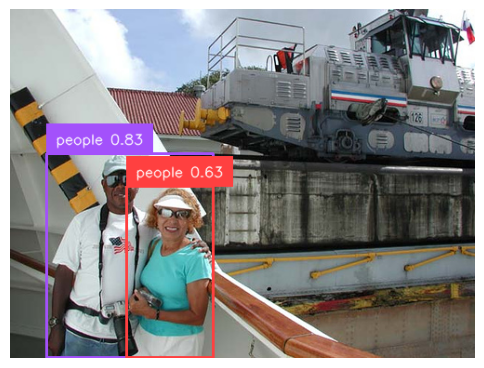

In [ ]:
import os
import supervision as sv

# Try any other image (0-> 1..5)
IMAGE_NAME = sample_image_paths[0]
IMAGE_PATH = os.path.join("../", IMAGE_NAME)

TEXT_PROMPT = "people" # Try any other object to detect, just write a word
BOX_TRESHOLD = 0.35 # You can change that too
TEXT_TRESHOLD = 0.25 # And this too ;)

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (6, 6))

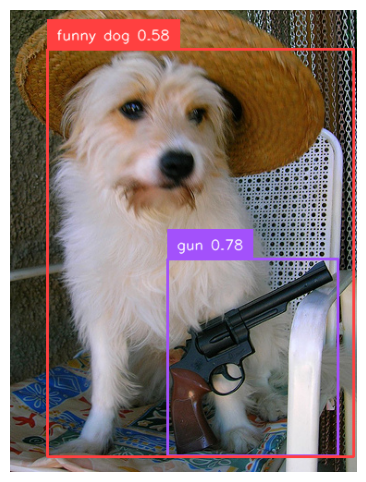

In [ ]:
# Another example
import os
import supervision as sv

# Try any other image (0-> 1..5)
IMAGE_NAME = sample_image_paths[3]
IMAGE_PATH = os.path.join("../", IMAGE_NAME)

TEXT_PROMPT = "funny dog . gun" # Try any other object to detect, just write a word
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (6, 6))